In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

In [3]:
review_df = pd.read_csv('Fine_Food_Reviews.csv')
review_df = review_df[['ProductId', 'UserId', 'Score', 'Text']]
review_df = review_df.rename(columns={"ProductId": "asin", "UserId": "reviewerID",
                                          "Text": "reviewText"})
review_df = review_df.drop_duplicates(subset='reviewText', keep="first")

## Getting an overview of the data

In [4]:
review_df

,asin,reviewerID,Score,reviewText
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...
...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,5,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,2,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,5,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,5,These are the BEST treats for training and rew...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


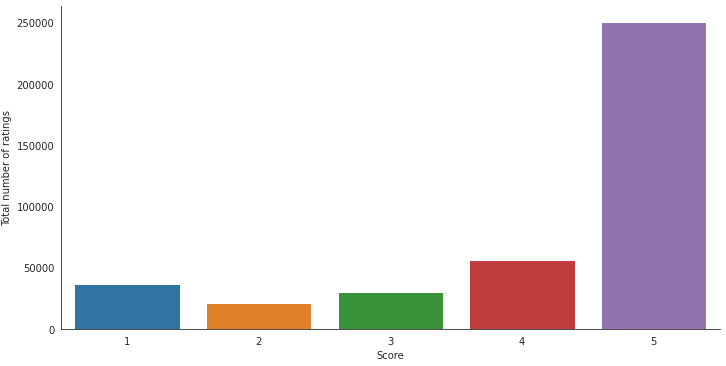

In [5]:
with sns.axes_style('white'):
    g = sns.factorplot("Score", data=review_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

## Getting an overview of the most important info

In [6]:
print("Number of users:", len(review_df.groupby('reviewerID').count()))
userID = review_df.groupby('reviewerID').count()
top_users = userID[userID['Score'] >= 20].index
top_users_df = review_df[review_df['reviewerID'].isin(top_users)]
top_users_df = top_users_df[['reviewerID', 'asin', 'Score', 'reviewText']]
print("Users who have given at least " + "20" + " Reviews:", len(top_users_df))
productID = review_df.groupby('asin').count()
print("# of products:", len(productID))
top_products = productID[productID['Score'] >= 20].index
top_products_df = top_users_df[top_users_df['asin'].isin(top_products)]
df_filtered = top_products_df[['reviewerID', 'asin', 'Score', 'reviewText']]
df_filtered['pos_neg'] = [1 if x > 3 else 0 for x in df_filtered.Score]
print("final DF after filtering:\n")
df_filtered

Number of users: 256044
Users who have given at least 20 Reviews: 26284
# of products: 67554
final DF after filtering:



,reviewerID,asin,Score,reviewText,pos_neg
431,A2OEUROGZDTXUJ,B000G6RYNE,5,"Now, I haven't done a side-by-side comparison,...",1
433,A22PUBSSNP54L,B000G6RYNE,5,These chips are thick and crunchy. I absolute...,1
443,AYB4ELCS5AM8P,B000G6RYNE,5,What I like about them:<br />1) Very thick chi...,1
444,A2GOE7ITDGYVE,B000G6RYNE,5,These are so tangy it prevents me from eating ...,1
446,A3PZ4AXTY9J1DZ,B000G6RYNE,4,I have always been a fan of Kettle chips. Whe...,1
...,...,...,...,...,...
567567,A3T0OTH5072YRE,B001BKLHMI,4,I've discovered that I really like the Kashi G...,1
567577,A3H7AOFQDPU0JV,B001BKLHMI,5,I have reviewed a lot of these snack bars over...,1
568249,A17V9XL4CWTQ6G,B00374ZKQ0,1,"First of all, I have no ties with Truvia. In f...",0
568261,A2GEZJHBV92EVR,B00374ZKQ0,5,I have tried many of the no sugar sweeteners o...,1


## Now, we'll transpose the data

In [7]:
ratings_matrix = pd.pivot_table(df_filtered,index=['reviewerID'], columns = 'asin', values = "Score")
ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = ratings_matrix.shape[0] * ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (707, 2501)
given_num_of_ratings =  12457
possible_num_of_ratings =  1768207
density: 0.70%


In [8]:
ratings_matrix

asin,B00004RAMY,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000084ETV,B000084F1I,B000084F5E,B00008JOL0,B0000C69FB,...,B008YA1NWC,B008YA1R8W,B008Z4VAPM,B008ZRKZSM,B0090X8IPM,B0090X8JUG,B00954NYVY,B0096EZHM2,B009M2LPHO,B009M2LUEW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DRHWKS6NQUX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYNAH993VDECT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
AYOMAHLWRQHUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYWUHB7N8XGZQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


# Building a popularity recommender model

In [9]:
train_data, test_data = train_test_split(df_filtered, test_size = 0.2, random_state=0)

In [10]:
# Getting the count of unique products
train_data_grouped = train_data.groupby('asin').agg({'reviewerID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'reviewerID': 'score'},inplace=True)
train_data_grouped.head()

,asin,score
0,B00004RAMY,2
1,B00004RBDU,1
2,B00004RBDZ,1
3,B00004RYGX,4
4,B000084ETV,1


In [11]:
# Sorting based on score
train_data_sort = train_data_grouped.sort_values(['score', 'asin'], ascending = [0,1]) 
      
# Generating ranks based on score
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
# Top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,asin,score,Rank
1696,B002IEZJMA,137,1.0
1695,B002IEVJRY,124,2.0
2208,B006MONQMC,123,3.0
2152,B005HG9ESG,116,4.0
1708,B002LANN56,109,5.0


In [12]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    # This is the user who we're recommending to
    user_recommendations['UserId'] = user_id 
      
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

### An example of how it works

In [13]:
find_recom = [1, 2]   # The user ID's goes here
for i in find_recom:
    print("Here is the recommendation for User: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for User: 1

      UserId        asin  score  Rank
1696       1  B002IEZJMA    137   1.0
1695       1  B002IEVJRY    124   2.0
2208       1  B006MONQMC    123   3.0
2152       1  B005HG9ESG    116   4.0
1708       1  B002LANN56    109   5.0


Here is the recommendation for User: 2

      UserId        asin  score  Rank
1696       2  B002IEZJMA    137   1.0
1695       2  B002IEVJRY    124   2.0
2208       2  B006MONQMC    123   3.0
2152       2  B005HG9ESG    116   4.0
1708       2  B002LANN56    109   5.0




<ipython-input-12-b746413aca3e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['UserId'] = user_id
<ipython-input-12-b746413aca3e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['UserId'] = user_id


### Note: The products are the same because we're using a popularity recommender

## Let's try a more personal approach with user-based collaborative filtering

In [14]:
cf_df = pd.concat([train_data, test_data]).reset_index()
cf_df.head()

,index,reviewerID,asin,Score,reviewText,pos_neg
0,371531,A23E9ZPS2RQZS0,B001HN5Z4K,5,I have thrown away so many packages of treats ...,1
1,353655,A1Z7Y2GMAP9SRY,B005A1LINC,1,This did not tickle my taste buds. I really wa...,0
2,318945,A1VBDMNT6I8RE5,B005BPVA08,5,"Eat. Think. Smile. Crispy Thins, Savory Sea Sa...",1
3,146314,A3OXHLG6DIBRW8,B0000DID5R,5,"""Dave's Insanity Sauce"" is not to be taken cas...",1
4,521433,APVK8GGSSUDCE,B007JFXWRC,5,I like everything about Lipton's Blackberry Va...,1


In [15]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = pd.pivot_table(cf_df,index=['reviewerID'], columns = 'asin', values = "Score")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

(707, 2501)


asin,B00004RAMY,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000084ETV,B000084F1I,B000084F5E,B00008JOL0,B0000C69FB,...,B008YA1NWC,B008YA1R8W,B008Z4VAPM,B008ZRKZSM,B0090X8IPM,B0090X8JUG,B00954NYVY,B0096EZHM2,B009M2LPHO,B009M2LUEW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DRHWKS6NQUX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head() # These are the ratings given by each user

asin,B00004RAMY,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000084ETV,B000084F1I,B000084F5E,B00008JOL0,B0000C69FB,...,B008YA1NWC,B008YA1R8W,B008Z4VAPM,B008ZRKZSM,B0090X8IPM,B0090X8JUG,B00954NYVY,B0096EZHM2,B009M2LPHO,B009M2LUEW
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Since the data is quite sparse, the best method is SVD

In [17]:
U, sigma, Vt = svds(pivot_df, k = 50)
sigma = np.diag(sigma)
user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Getting the predicted ratings
preds_df = pd.DataFrame(user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

asin,B00004RAMY,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000084ETV,B000084F1I,B000084F5E,B00008JOL0,B0000C69FB,...,B008YA1NWC,B008YA1R8W,B008Z4VAPM,B008ZRKZSM,B0090X8IPM,B0090X8JUG,B00954NYVY,B0096EZHM2,B009M2LPHO,B009M2LUEW
0,-0.034693,0.257845,0.329418,0.008172,0.188919,0.178133,-0.006041,0.021829,0.081219,0.002046,...,0.290625,0.023276,0.014922,0.027036,2.403365,0.054122,0.189776,-0.036342,-0.080469,0.327399
1,0.003188,-0.002634,-0.002563,-0.014289,0.026742,-0.022098,0.002168,-0.000705,-0.015121,-0.007284,...,-0.006924,-0.001670,0.004093,0.027292,-0.137428,0.002549,-0.005594,0.043932,0.005967,0.071542
2,0.008102,-0.011774,0.017539,-0.006296,-0.051250,0.003843,0.004773,-0.000582,0.024007,-0.001678,...,-0.053834,0.004890,-0.004031,0.029079,-0.190450,-0.002868,-0.013510,0.004775,-0.008187,-0.005529
3,-0.021861,0.059809,0.012110,-0.043330,0.199809,0.007016,0.013653,-0.004128,-0.047639,-0.121580,...,-0.008767,0.019788,0.029682,0.064759,0.218358,-0.024094,-0.036246,-0.230916,-0.037403,0.191115
4,0.011175,0.016179,0.090154,-0.006864,-0.000455,0.015454,0.001844,0.000172,0.001254,-0.006550,...,0.023044,-0.001102,0.001785,0.025686,0.273812,0.009982,0.010682,-0.038184,0.005142,0.039729


### Now, the highest predicted ratings we'll be recommended

In [18]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    

    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nThese are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

### An example of how this function works

In [19]:
userID = 10
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


These are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B007RTR8T8                  0.0          1.616939
B007RTR8UM                  0.0          1.605053
B004JRO1S2                  0.0          1.481961
B000FA38ZY                  0.0          1.317379
B001AHJ2D8                  0.0          1.315830


Note: The user predictions are given with the most likely products first

## Now, RMSE will be generated along with the actual recommendations

In [21]:
rmse_df = pd.concat([ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_pred_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(2501, 2)


,Avg_actual_ratings,Avg_pred_ratings,item_index
asin,,,
B00004RAMY,0.021216,0.009519,0
B00004RBDU,0.008487,0.007896,1
B00004RBDZ,0.007072,0.011772,2
B00004RYGX,0.031117,0.013390,3
B00004S1C6,0.014144,0.014701,4


In [23]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_pred_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00757 



In [24]:
userID = 42
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


These are the recommended items for user(user_id = 42):

                   user_ratings  user_predictions
Recommended Items                                
B001LGGH40                  0.0          2.061410
B005VOONKI                  0.0          1.343216
B004YV80O4                  0.0          1.317917
B007TGO1TY                  0.0          0.921433
B0041CIP3M                  0.0          0.918117


### In summary, popularity based models aren't as effective because they aren't as personal. The benefit of personalized models like the one above is that they take past purchases into account.